In [1]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import plotly.subplots as sp
import math

from plotly.subplots import make_subplots
from scipy.stats import mode
from scipy.integrate import cumulative_trapezoid
from scipy.signal import correlate
import json
%config Completer.use_jedi = False  # Fixes autocomplete issues
%config InlineBackend.figure_format = 'retina'  # Improves plot resolution

import gc # garbage collector for removing large variables from memory instantly 
import importlib #for force updating changed packages 

#import harp
import harp_resources.process
import harp_resources.utils
from harp_resources import process, utils # Reassign to maintain direct references for force updating 
#from sleap import load_and_process as lp

In [2]:
#-------------------------------
# data paths setup
#-------------------------------
data_dirs = [       #add your data directories here
    Path('/Volumes/RanczLab2/20250409_Cohort3_rotation/Visual_mismatch_day3').expanduser(),
    Path('/Volumes/RanczLab2/20250409_Cohort3_rotation/Visual_mismatch_day4').expanduser()
]
# Collect raw data paths (excluding '_processedData' dirs)
rawdata_paths = []
for data_dir in data_dirs:
    subdirs = [p for p in data_dir.iterdir() if p.is_dir() and not p.name.endswith('_processedData')]
    rawdata_paths.append(subdirs[0])  # select mouse

# Build processed data paths
data_paths = [raw.parent / f"{raw.name}_processedData/downsampled_data" for raw in rawdata_paths]
#-------------------------------
# initial variables setup
#-------------------------------
time_window_start = -6  # s, FOR PLOTTING PURPOSES
time_window_end = 10  # s, FOR PLOTTING PURPOSES
baseline_window = (-1, 0) # s, FOR baselining averages 
plot_width= 14

event_name = "Apply halt: 2s" #Apply halt: 2s, No halt
vestibular_mismatch = False
common_resampled_rate = 1000 #in Hz
plot_fig1 = False

# for saccades
framerate = 59.77  # Hz (in the future, should come from saved data)
threshold = 65  # px/s FIXME make this adaptive
refractory_period = pd.Timedelta(milliseconds=100)  # msec, using pd.Timedelta for datetime index
plot_saccade_detection_QC = False


In [3]:
#-------------------------------
# load downsampled data for each data path
#-------------------------------
loaded_data = {}  # Dictionary to store loaded data for each path

for idx, data_path in enumerate(data_paths, start=1):
    print(f"\nProcessing data path {idx}/{len(data_paths)}: {data_path}")
    try:
        # Load all parquet files for this data path
        photometry_tracking_encoder_data = pd.read_parquet(data_path / "photometry_tracking_encoder_data.parquet", engine="pyarrow")
        camera_photodiode_data = pd.read_parquet(data_path / "camera_photodiode_data.parquet", engine="pyarrow")
        experiment_events = pd.read_parquet(data_path / "experiment_events.parquet", engine="pyarrow")
        photometry_info = pd.read_parquet(data_path / "photometry_info.parquet", engine="pyarrow")
        session_settings = pd.read_parquet(data_path / "session_settings.parquet", engine="pyarrow")
        session_settings["metadata"] = session_settings["metadata"].apply(process.safe_from_json)
        
        print(f"✅ Successfully loaded all parquet files for {data_path.name}")
        
        # Calculate time differences between event_name events
        event_times = experiment_events[experiment_events["Event"] == event_name].index
        if len(event_times) > 1:
            time_diffs = event_times.to_series().diff().dropna().dt.total_seconds()
            # Print the 5 shortest time differences
            # print("5 shortest time differences between events:")
            # print(time_diffs.nsmallest(5))
            if (time_diffs < 10).any():
                print(f"⚠️ Warning: Some '{event_name}' events are less than 10 seconds apart. Consider applying a filter to events.")
        else:
            print(f"ℹ️ INFO: Found {len(event_times)} events with name '{event_name}' - not enough to calculate differences")
        
        # Check experiment events and get mouse name
        mouse_name = process.check_exp_events(experiment_events, photometry_info, verbose=True)
        
        # Store all loaded data in the dictionary
        loaded_data[data_path] = {
            "photometry_tracking_encoder_data": photometry_tracking_encoder_data,
            "camera_photodiode_data": camera_photodiode_data,
            "experiment_events": experiment_events,
            "photometry_info": photometry_info,
            "session_settings": session_settings,
            "mouse_name": mouse_name
        }
        
    except Exception as e:
        print(f"⚠️ ERROR processing data path {data_path}: {str(e)}")
        continue

print(f"\n✅ Finished loading data for all {len(loaded_data)} successfully processed data paths")

# Now you can use loaded_data[data_path] to access the data for each path in your subsequent processing


Processing data path 1/2: /Volumes/RanczLab2/20250409_Cohort3_rotation/Visual_mismatch_day3/B6J2780-2025-04-25T11-51-53_processedData/downsampled_data
✅ Successfully loaded all parquet files for downsampled_data
ℹ️ Mousename: B6J2780
ℹ️ Unique events and their counts:
Event
Wait for run threshold...            8
Check halt probability               6
Halt delay: 0s                       4
Apply halt: 2s                       4
Block timer elapsed                  2
No halt                              2
Sync signal started                  1
Homing platform                      1
DrumBase block started               1
DrumWithReverseHalt block started    1
Name: count, dtype: int64
ℹ️ block events
                                                        Event  Time Difference
Time                                                                          
1904-01-01 21:27:25.110240             DrumBase block started              NaN
1904-01-01 21:32:25.430240                Block timer e


--------- Processing analysis for data path 1/2: /Volumes/RanczLab2/20250409_Cohort3_rotation/Visual_mismatch_day3/B6J2780-2025-04-25T11-51-53_processedData/downsampled_data ---------
⚠️ WARNING: Falling edges (5) and Apply halt: 2s events (4) do not match. Number of events: 5.
ℹ️ This happens occasionally. The following section prints the extra falling edges and their durations and report of if they were removed.
         Falling Edge Time  Duration (s)           Preceding Event Event Time Difference (s)
1904-01-01 21:44:01.667097         1.308 Wait for run threshold...                 98.866041


time difference between photodiode and experimenet events:
min 61.6 ms. avg 77.6 ms. max 89.9 ms.


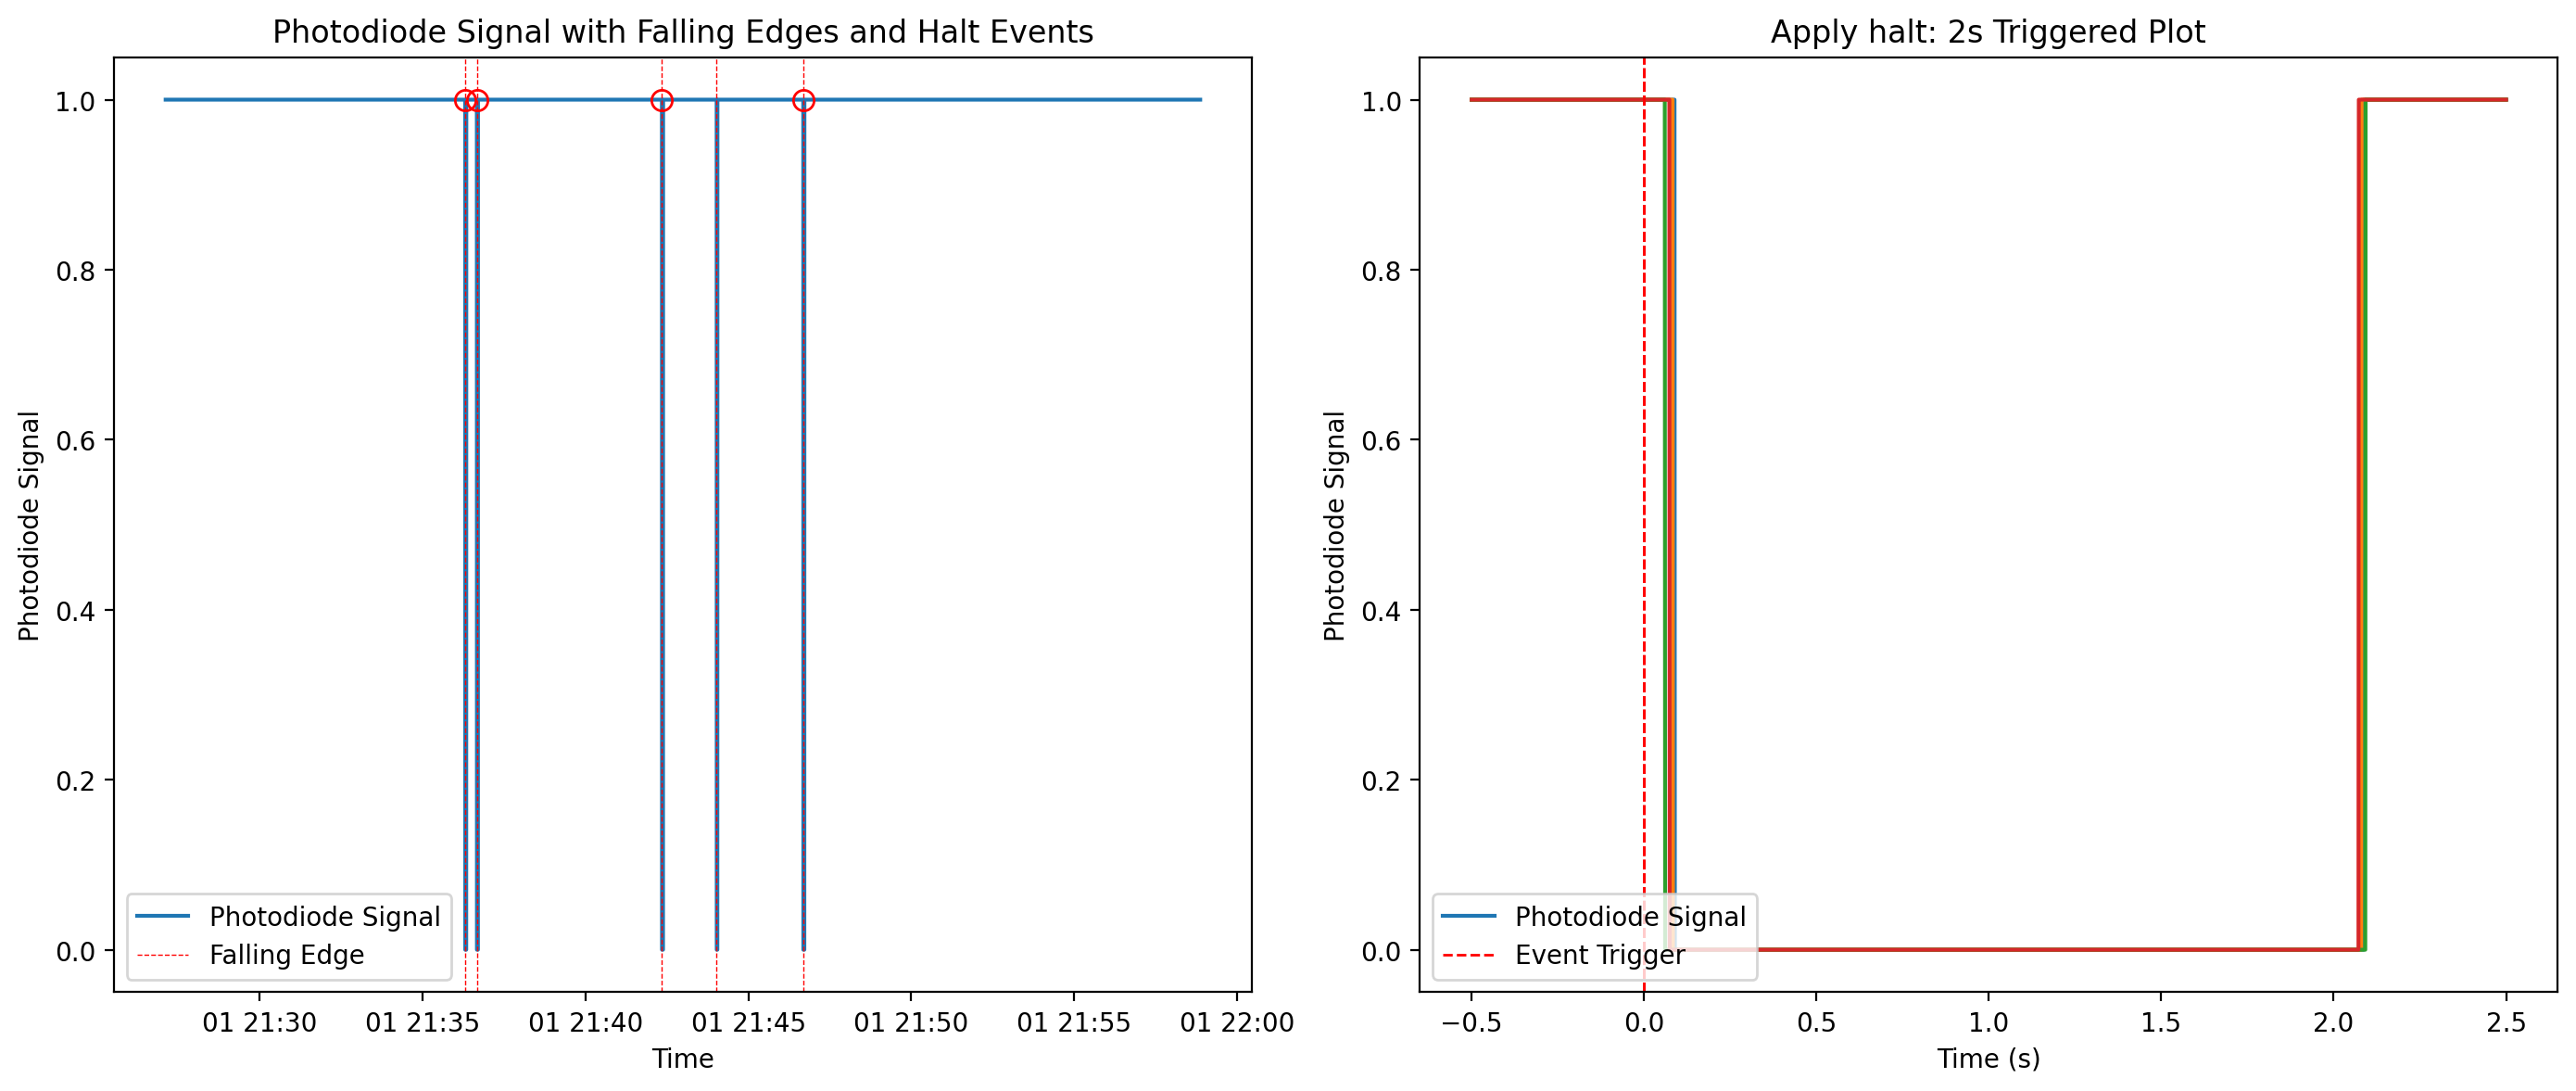

✅ 1 extra falling edges (outside 61.6ms - 89.9ms delay window) were removed before returning.
✅ Successfully analyzed photodiode signal for downsampled_data
ℹ️ INFO: skipping figure 1 for downsampled_data
✅ Completed analysis for data path: /Volumes/RanczLab2/20250409_Cohort3_rotation/Visual_mismatch_day3/B6J2780-2025-04-25T11-51-53_processedData/downsampled_data

--------- Processing analysis for data path 2/2: /Volumes/RanczLab2/20250409_Cohort3_rotation/Visual_mismatch_day4/B6J2780-2025-04-28T13-10-18_processedData/downsampled_data ---------
✅ 5 events found. Matching number of photodiode falling edges and 'Apply halt: 2s' events.
time difference between photodiode and experimenet events:
min 63.2 ms. avg 74.5 ms. max 89.0 ms.


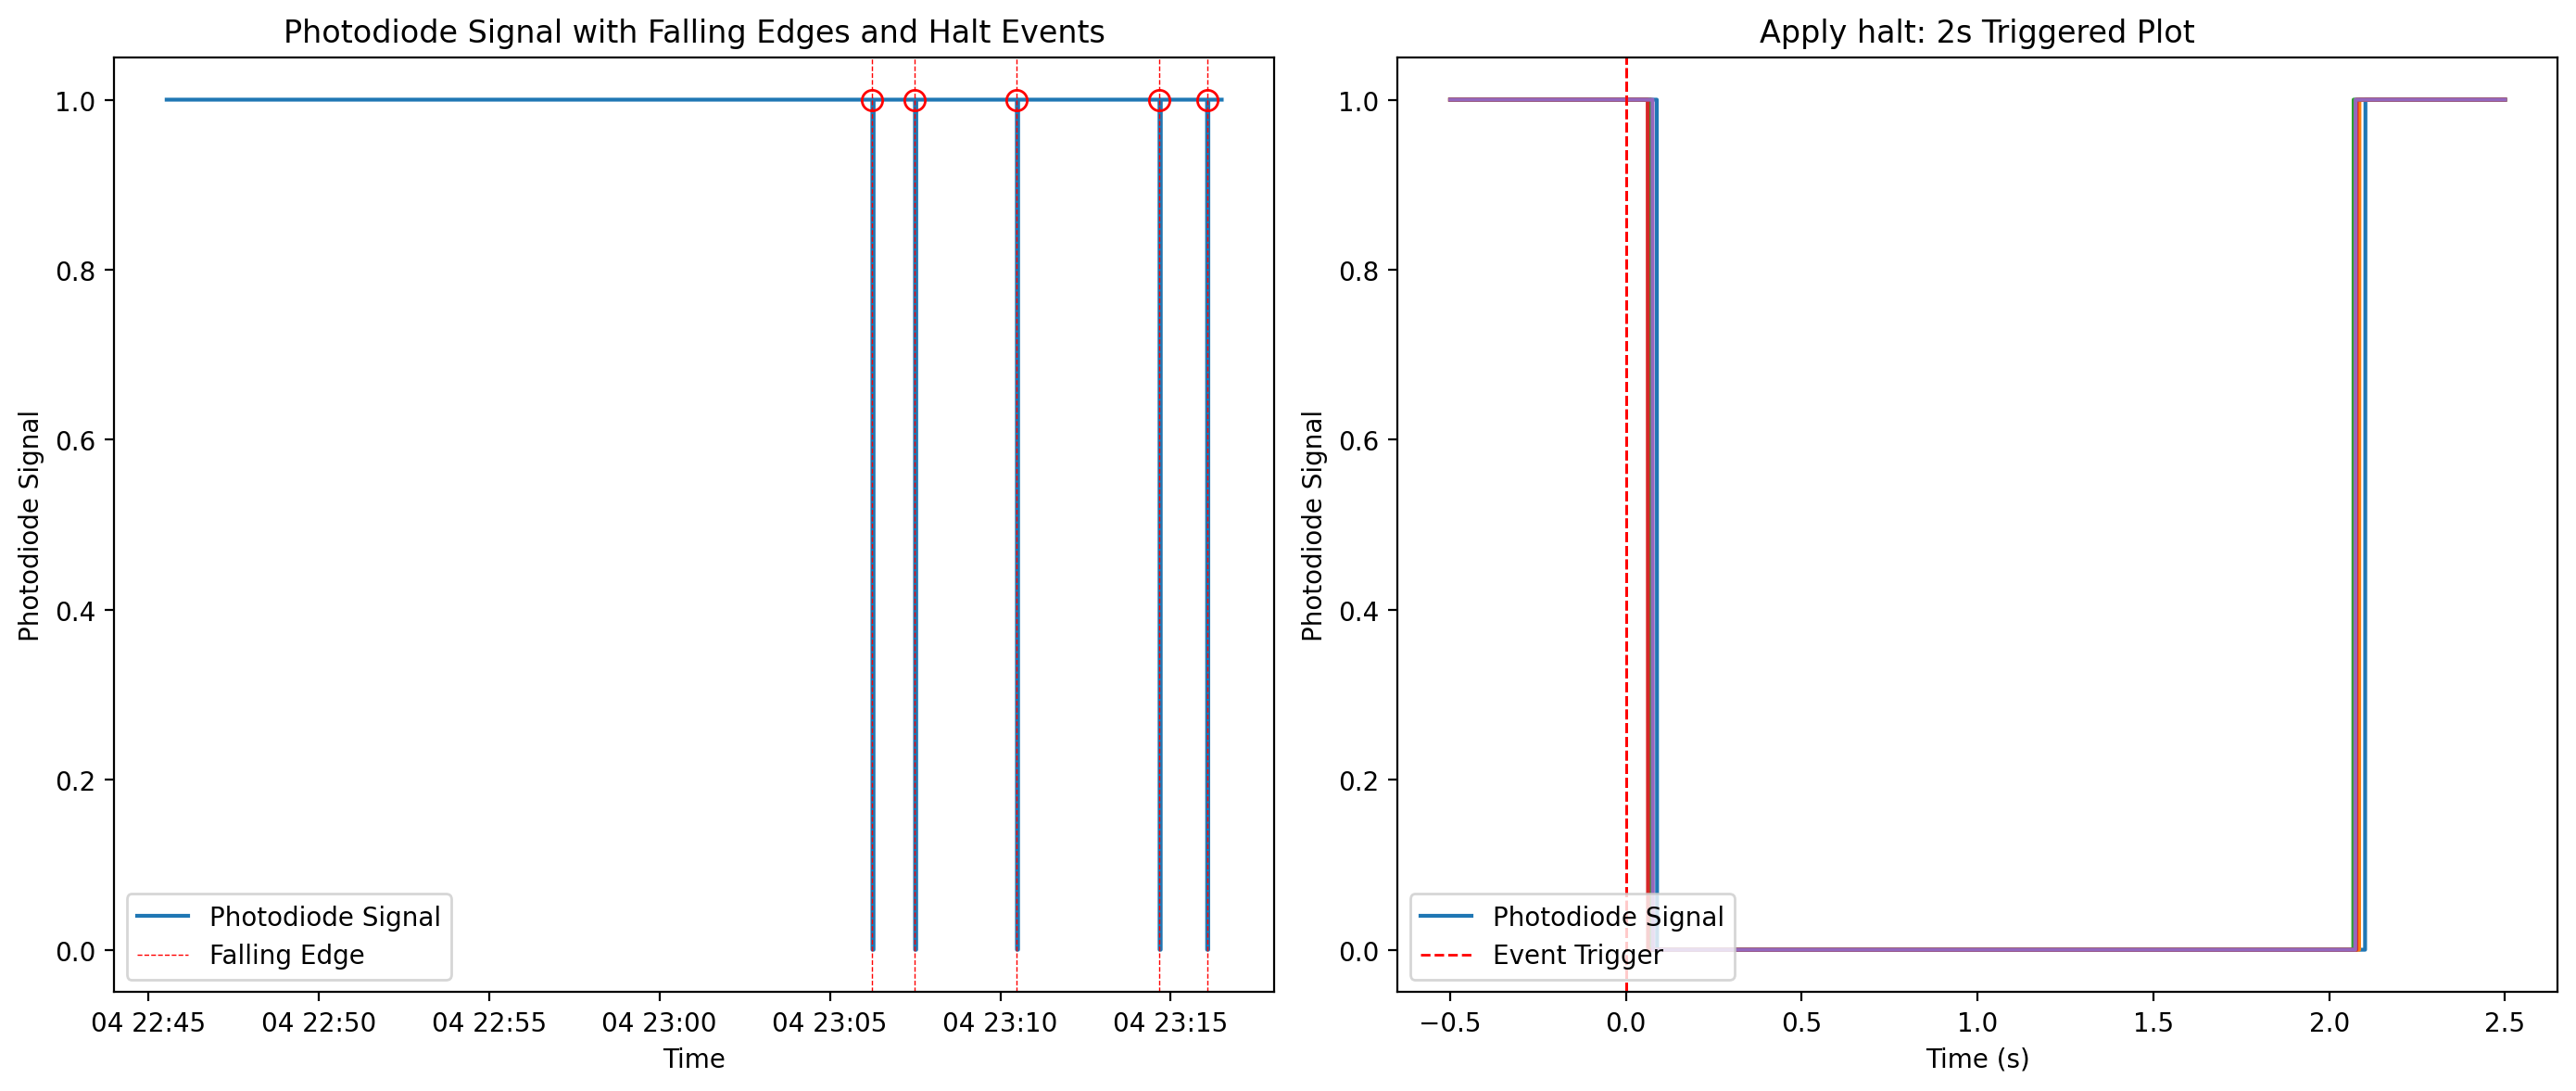

✅ 0 extra falling edges (outside 63.2ms - 89.0ms delay window) were removed before returning.
✅ Successfully analyzed photodiode signal for downsampled_data
ℹ️ INFO: skipping figure 1 for downsampled_data
✅ Completed analysis for data path: /Volumes/RanczLab2/20250409_Cohort3_rotation/Visual_mismatch_day4/B6J2780-2025-04-28T13-10-18_processedData/downsampled_data

✅ Finished analyzing all 2 successfully processed data paths


In [4]:
#---------------------------------------------------
# create DFs and plot figure for each data path
#---------------------------------------------------

# Dictionary to store analysis results for each data path
data_path_variables = {}

for idx, data_path in enumerate(data_paths, start=1):
    print(f"\n--------- Processing analysis for data path {idx}/{len(data_paths)}: {data_path} ---------")
    
    # Skip if data wasn't successfully loaded for this path
    if data_path not in loaded_data:
        print(f"⚠️ Skipping analysis for {data_path} - data not loaded successfully")
        continue
    
    try:
        # Extract data from loaded_data dictionary
        photometry_tracking_encoder_data = loaded_data[data_path]["photometry_tracking_encoder_data"]
        camera_photodiode_data = loaded_data[data_path]["camera_photodiode_data"]
        experiment_events = loaded_data[data_path]["experiment_events"]
        mouse_name = loaded_data[data_path]["mouse_name"]
        session_name = f"{mouse_name}_{data_path.name}"  # Assuming session_name is constructed this way
        
        # Create dataframe to analyze
        df_to_analyze = photometry_tracking_encoder_data["Photodiode_int"]  # Using downsampled values in common time grid
        # df_to_analyze = camera_photodiode_data["Photodiode"]  # Use async raw values if needed for troubleshooting
        
        # Determine halt times based on different conditions
        if vestibular_mismatch or event_name == "No halt":  # Determine halt times based on experiment events
            events_matching_name = experiment_events[experiment_events["Event"] == event_name]
            if events_matching_name.empty:
                print(f"⚠️ WARNING: No events found with name '{event_name}', skipping this data path")
                continue
                
            photodiode_halts = events_matching_name.index.tolist()
            nearest_indices = photometry_tracking_encoder_data.index.get_indexer(photodiode_halts, method='nearest')
            photodiode_halts = photometry_tracking_encoder_data.index[nearest_indices]  # Align to downsampled data time grid
            print(f"ℹ️ INFO: vestibular MM or 'No halt', no signal in the photodiode, using experiment events for MM times")
            photodiode_delay_min = photodiode_delay_avg = photodiode_delay_max = None
        else:  # Determine exact halt times based on photodiode signal
            try:
                photodiode_halts, photodiode_delay_min, photodiode_delay_avg, photodiode_delay_max = process.analyze_photodiode(
                    df_to_analyze, experiment_events, event_name, plot=True
                )
                print(f"✅ Successfully analyzed photodiode signal for {data_path.name}")
            except Exception as e:
                print(f"⚠️ ERROR analyzing photodiode signal: {str(e)}")
                continue
        
        # Store analysis results
        data_path_variables[data_path] = {
            "photodiode_halts": photodiode_halts,
            "photodiode_delay_min": photodiode_delay_min,
            "photodiode_delay_avg": photodiode_delay_avg,
            "photodiode_delay_max": photodiode_delay_max,
            "session_name": session_name
        }
        
        # Plot figure if requested
        if plot_fig1:
            try:
                process.plot_figure_1(
                    photometry_tracking_encoder_data, 
                    session_name, 
                    save_path, 
                    common_resampled_rate, 
                    photodiode_halts, 
                    save_figure=True, 
                    show_figure=True, 
                    downsample_factor=50
                )
                print(f"✅ Successfully created figure 1 for {data_path.name}")
            except Exception as e:
                print(f"⚠️ ERROR creating figure 1: {str(e)}")
        else:
            print(f"ℹ️ INFO: skipping figure 1 for {data_path.name}")
        
        # Clean up to free memory
        del df_to_analyze
        gc.collect()
        
        print(f"✅ Completed analysis for data path: {data_path}")
        
    except Exception as e:
        print(f"⚠️ ERROR during analysis of {data_path}: {str(e)}")

print(f"\n✅ Finished analyzing all {len(data_path_variables)} successfully processed data paths")

In [5]:
# #---------------------------------------------------
# # Create aligned data and plot fluorescence traces for each data path (with improved error handling)
# #---------------------------------------------------

# # Check if required variables exist
# required_vars = ['time_window_start', 'time_window_end']
# for var in required_vars:
#     if var not in globals():
#         print(f"⚠️ ERROR: Required variable '{var}' is not defined")
#         # Set default values
#         if var == 'time_window_start':
#             time_window_start = -5  # Default: 5 seconds before halt
#             print(f"  Setting default value: {var} = {time_window_start}")
#         elif var == 'time_window_end':
#             time_window_end = 10  # Default: 10 seconds after halt
#             print(f"  Setting default value: {var} = {time_window_end}")

# # Define save_plots if not already defined
# if 'save_plots' not in globals():
#     save_plots = False
#     print(f"Setting default value: save_plots = {save_plots}")

# for idx, data_path in enumerate(data_paths, start=1):
#     print(f"\n--------- Creating fluorescence plots for data path {idx}/{len(data_paths)}: {data_path} ---------")
    
#     # Skip if data wasn't successfully analyzed for this path
#     if data_path not in data_path_variables:
#         print(f"⚠️ Skipping fluorescence plots for {data_path} - analysis not completed successfully")
#         continue
    
#     try:
#         # Verify data exists before attempting to extract it
#         if data_path not in loaded_data:
#             print(f"⚠️ ERROR: data_path {data_path} not found in loaded_data")
#             continue
            
#         if "photometry_tracking_encoder_data" not in loaded_data[data_path]:
#             print(f"⚠️ ERROR: 'photometry_tracking_encoder_data' not found in loaded_data[{data_path}]")
#             continue
            
#         if "photodiode_halts" not in data_path_variables[data_path]:
#             print(f"⚠️ ERROR: 'photodiode_halts' not found in data_path_variables[{data_path}]")
#             continue
            
#         # Extract data from loaded_data and data_path_variables dictionaries
#         photometry_tracking_encoder_data = loaded_data[data_path]["photometry_tracking_encoder_data"]
#         photodiode_halts = data_path_variables[data_path]["photodiode_halts"]
        
#         # Check if session_name exists in data_path_variables
#         if "session_name" in data_path_variables[data_path]:
#             session_name = data_path_variables[data_path]["session_name"]
#         else:
#             # Try to generate session_name
#             if "mouse_name" in loaded_data[data_path]:
#                 mouse_name = loaded_data[data_path]["mouse_name"]
#                 session_name = f"{mouse_name}_{data_path.name}"
#             else:
#                 session_name = f"session_{data_path.name}"
#                 print(f"⚠️ WARNING: Using generic session name: {session_name}")
        
#         print(f"Creating aligned data for {len(photodiode_halts)} events in {data_path.name}")
        
#         # Check if required columns exist in photometry data
#         required_columns = ["z_470", "z_560"]
#         missing_columns = [col for col in required_columns if col not in photometry_tracking_encoder_data.columns]
#         if missing_columns:
#             print(f"⚠️ ERROR: Missing columns in photometry_tracking_encoder_data: {missing_columns}")
#             print(f"Available columns: {photometry_tracking_encoder_data.columns.tolist()}")
#             continue
        
#         # --- Data Alignment ---
#         aligned_data = []
#         for halt_time in photodiode_halts:
#             try:
#                 window_data = photometry_tracking_encoder_data.loc[
#                     (photometry_tracking_encoder_data.index >= halt_time + pd.Timedelta(seconds=time_window_start)) &
#                     (photometry_tracking_encoder_data.index <= halt_time + pd.Timedelta(seconds=time_window_end))
#                 ].copy()
                
#                 if window_data.empty:
#                     print(f"⚠️ WARNING: No data found for window around halt time {halt_time}")
#                     continue
                    
#                 window_data["Time (s)"] = (window_data.index - halt_time).total_seconds()
#                 window_data["Halt Time"] = halt_time
#                 aligned_data.append(window_data)
#             except Exception as e:
#                 print(f"⚠️ ERROR processing halt time {halt_time}: {str(e)}")
#                 continue
        
#         if not aligned_data:
#             print(f"⚠️ WARNING: No aligned data created for {data_path.name}, skipping plotting")
#             continue
            
#         aligned_df = pd.concat(aligned_data, ignore_index=True)
        
#         # --- Subplot Grid Setup ---
#         n_events = len(photodiode_halts)
#         n_cols = 4
#         n_rows = math.ceil(n_events / n_cols)
        
#         print(f"Creating subplot grid with {n_rows} rows and {n_cols} columns for {n_events} events")
        
#         # Create subplots with a single (default) y-axis in each cell
#         specs = [[{} for _ in range(n_cols)] for _ in range(n_rows)]
#         subplot_titles = [f'Event: {halt_time}' for halt_time in photodiode_halts]
#         fig = sp.make_subplots(rows=n_rows, cols=n_cols, subplot_titles=subplot_titles, specs=specs)
        
#         # Base extra is used to create unique axis IDs starting after the auto-assigned primary axes
#         base_extra = n_events + 1
        
#         for i, halt_time in enumerate(photodiode_halts):
#             try:
#                 row = (i // n_cols) + 1
#                 col = (i % n_cols) + 1
                
#                 subset = aligned_df[aligned_df["Halt Time"] == halt_time]
#                 if subset.empty:
#                     print(f"⚠️ WARNING: No data found for halt time {halt_time}")
#                     continue
                
#                 # Verify data exists in subset
#                 for col_name in ["Time (s)", "z_470", "z_560"]:
#                     if col_name not in subset.columns:
#                         print(f"⚠️ ERROR: Column '{col_name}' not found in aligned data subset")
#                         print(f"Available columns: {subset.columns.tolist()}")
#                         raise KeyError(f"Missing column: {col_name}")
                    
#                 # -- Fluorescence Traces on Primary y-axis --
#                 fig.add_trace(
#                     go.Scatter(
#                         x=subset["Time (s)"],
#                         y=subset["z_470"],
#                         mode='lines',
#                         name='z_470',
#                         line=dict(color='green')
#                     ),
#                     row=row, col=col
#                 )
                
#                 fig.add_trace(
#                     go.Scatter(
#                         x=subset["Time (s)"],
#                         y=subset["z_560"],
#                         mode='lines',
#                         name='z_560',
#                         line=dict(color='red')
#                     ),
#                     row=row, col=col
#                 )
                
#                 # Determine the subplot's x-axis anchor
#                 xaxis_number = (row - 1) * n_cols + col
#                 x_anchor = "x" if xaxis_number == 1 else f"x{xaxis_number}"
                
#                 # The primary y-axis for this subplot
#                 primary_y = "y" if xaxis_number == 1 else f"y{xaxis_number}"
                
#             except Exception as e:
#                 print(f"⚠️ ERROR processing subplot for halt time {halt_time}: {str(e)}")
#                 continue
        
#         # --- Update Common Axis Labels ---
#         fig.update_xaxes(title_text="Time (s)")
#         fig.update_yaxes(title_text="Fluorescence (z-score)")
        
#         # Create a descriptive title that includes session name
#         title = f"Fluorescence for each event - {session_name}"
        
#         fig.update_layout(
#             height=400 * n_rows,
#             width=350 * n_cols,
#             title_text=title,
#             template='plotly_white'
#         )
        
#         # Save the figure if needed
#         if save_plots:
#             try:
#                 # Ensure save_path exists
#                 if 'save_path' not in globals() or save_path is None:
#                     from pathlib import Path
#                     save_path = Path('./output')
#                     save_path.mkdir(exist_ok=True)
#                     print(f"Creating default save_path: {save_path}")
                    
#                 output_file = save_path / f"{session_name}_fluorescence_events.html"
#                 fig.write_html(str(output_file))
#                 print(f"✅ Saved fluorescence plot to {output_file}")
#             except Exception as e:
#                 print(f"⚠️ ERROR saving fluorescence plot: {str(e)}")
        
#         # Display the figure
#         fig.show()
        
#         # Clean up to free memory
#         del aligned_data
#         gc.collect()
        
#         print(f"✅ Completed fluorescence plots for data path: {data_path}")
        
#     except Exception as e:
#         import traceback
#         print(f"⚠️ ERROR creating fluorescence plots for {data_path}: {str(e)}")
#         print("Detailed error traceback:")
#         traceback.print_exc()  # This will print the full stack trace

# print(f"\n✅ Finished creating fluorescence plots for all successfully processed data paths")

In [6]:
#---------------------------------------------------
# Create aligned data and plot comprehensive figures for each data path
#---------------------------------------------------

print(f"Using time window: {time_window_start}s to {time_window_end}s relative to halt")

# Iterate through each data path
for idx, data_path in enumerate(data_paths, start=1):
    print(f"\n--------- Processing {idx}/{len(data_paths)}: {data_path} ---------")
    
    if data_path not in data_path_variables:
        print(f"⚠️ Skipping {data_path} - no analysis data found")
        continue
    
    try:
        # Extract data
        data = loaded_data[data_path]
        vars_ = data_path_variables[data_path]
        
        df = data["photometry_tracking_encoder_data"]
        halts = vars_["photodiode_halts"]
        
        session_name = vars_.get("session_name")
        if not session_name:
            mouse_name = data.get("mouse_name", "unknown_mouse")
            session_name = f"{mouse_name}_{data_path.stem}"
            print(f"⚠️ No session_name found, using: {session_name}")

        event_name = event_name
        print(f"Aligning {len(halts)} events for session '{session_name}'")

        # Align data to each halt event
        aligned_data = []
        for i, halt_time in enumerate(halts):
            window = df.loc[
                (df.index >= halt_time + pd.Timedelta(seconds=time_window_start)) &
                (df.index <= halt_time + pd.Timedelta(seconds=time_window_end))
            ].copy()

            if window.empty:
                print(f"⚠️ No data in window around halt {halt_time}")
                continue

            window["Time (s)"] = (window.index - halt_time).total_seconds()
            window["Halt Time"] = halt_time
            aligned_data.append(window)

        if not aligned_data:
            print(f"⚠️ No aligned data generated for {session_name}, skipping")
            continue

        aligned_df = pd.concat(aligned_data, ignore_index=True)

        # Save CSV in same folder as data
        aligned_dir = data_path.parent / "aligned_data"
        aligned_dir.mkdir(exist_ok=True)

        aligned_file = aligned_dir / f"{session_name}_{event_name}_aligned.csv"
        aligned_df.to_csv(aligned_file, index=False)
        print(f"✅ Saved aligned data to {aligned_file}")

        # Fill in missing columns with dummy data (except required)
        required_columns = ["Time (s)", "Photodiode_int", "z_470", "z_560", "Motor_Velocity", "Velocity_0X", "Velocity_0Y"]
        for col in required_columns:
            if col not in aligned_df.columns:
                print(f"⚠️ Missing column: {col}, adding zeros")
                aligned_df[col] = 0

        # Compute group mean and SEM
        mean_df = aligned_df.groupby("Time (s)").mean()
        sem_df = aligned_df.groupby("Time (s)").sem()

        # Create figure
        print(f"📈 Creating plot for {session_name}")
        fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

        ## Plot 1: Individual Traces
        ax1 = axes[0]
        for halt in aligned_df["Halt Time"].unique():
            subset = aligned_df[aligned_df["Halt Time"] == halt]
            ax1.plot(subset["Time (s)"], subset["Photodiode_int"], color='grey', alpha=0.5)

        ax1.set_title('Photodiode, z_470, and z_560')
        ax1.set_xlabel("Time (s)")
        ax1.set_ylabel("Photodiode")

        ax1_2 = ax1.twinx()
        for halt in aligned_df["Halt Time"].unique():
            subset = aligned_df[aligned_df["Halt Time"] == halt]
            ax1_2.plot(subset["Time (s)"], subset["z_470"], color='green', alpha=0.5)
            ax1_2.plot(subset["Time (s)"], subset["z_560"], color='red', alpha=0.5)

        ax1_2.set_ylabel("Fluorescence (z-score)", color='green')

        ## Plot 2: Mean + SEM
        ax2 = axes[1]
        ax2.plot(mean_df.index, mean_df["Photodiode_int"], color='grey')
        ax2.fill_between(mean_df.index, mean_df["Photodiode_int"] - sem_df["Photodiode_int"],
                         mean_df["Photodiode_int"] + sem_df["Photodiode_int"], color='grey', alpha=0.2)
        ax2.set_xlabel("Time (s)")
        ax2.set_ylabel("Photodiode")
        ax2.set_title("Mean & SEM")

        ax2_2 = ax2.twinx()
        ax2_2.plot(mean_df.index, mean_df["z_470"], color='green')
        ax2_2.fill_between(mean_df.index, mean_df["z_470"] - sem_df["z_470"], 
                           mean_df["z_470"] + sem_df["z_470"], color='green', alpha=0.2)

        ax2_2.plot(mean_df.index, mean_df["z_560"], color='red')
        ax2_2.fill_between(mean_df.index, mean_df["z_560"] - sem_df["z_560"], 
                           mean_df["z_560"] + sem_df["z_560"], color='red', alpha=0.2)

        ax2_2.set_ylabel("Fluorescence (z-score)", color='green')

        # Save figure in same folder as data
        fig.suptitle(f"{session_name} - {event_name}")
        fig.tight_layout()
        figure_file = data_path.parent / f"{session_name}_{event_name}.pdf"
        fig.savefig(figure_file, dpi=300)
        plt.close(fig)
        print(f"✅ Saved figure to {figure_file}")

    except Exception as e:
        import traceback
        print(f"❌ ERROR processing {data_path}: {str(e)}")
        traceback.print_exc()

print("\n✅ Finished all data paths.")


Using time window: -6s to 10s relative to halt

--------- Processing 1/2: /Volumes/RanczLab2/20250409_Cohort3_rotation/Visual_mismatch_day3/B6J2780-2025-04-25T11-51-53_processedData/downsampled_data ---------
Aligning 4 events for session 'B6J2780_downsampled_data'
✅ Saved aligned data to /Volumes/RanczLab2/20250409_Cohort3_rotation/Visual_mismatch_day3/B6J2780-2025-04-25T11-51-53_processedData/aligned_data/B6J2780_downsampled_data_Apply halt: 2s_aligned.csv
📈 Creating plot for B6J2780_downsampled_data
✅ Saved figure to /Volumes/RanczLab2/20250409_Cohort3_rotation/Visual_mismatch_day3/B6J2780-2025-04-25T11-51-53_processedData/B6J2780_downsampled_data_Apply halt: 2s.pdf

--------- Processing 2/2: /Volumes/RanczLab2/20250409_Cohort3_rotation/Visual_mismatch_day4/B6J2780-2025-04-28T13-10-18_processedData/downsampled_data ---------
Aligning 5 events for session 'B6J2780_downsampled_data'
✅ Saved aligned data to /Volumes/RanczLab2/20250409_Cohort3_rotation/Visual_mismatch_day4/B6J2780-2025-

In [7]:
def process_data_path(aligned_df, baseline_window, mouse_name):
    # ---------------- Baseline Correction ----------------
    baseline_df = aligned_df[
        (aligned_df["Time (s)"] >= baseline_window[0]) & 
        (aligned_df["Time (s)"] <= baseline_window[1])
    ].groupby("Halt Time").mean()

    for signal_name in ["z_470", "z_560", "Motor_Velocity", "Velocity_0X", "Velocity_0Y"]:
        aligned_df[f"{signal_name}_Baseline"] = aligned_df[signal_name] - aligned_df["Halt Time"].map(baseline_df[signal_name])

    # ---------------- Mean and SEM ----------------
    mean_baseline_df = aligned_df.groupby("Time (s)").mean()
    sem_baseline_df = aligned_df.groupby("Time (s)").sem()

    def get_symmetric_ylim(mean_data, sem_data):
        max_abs_value = max(
            abs(mean_data).max() + sem_data.max(),
            abs(mean_data).min() - sem_data.min()
        )
        return (-max_abs_value, max_abs_value)

    # ---------------- Plotting ----------------
    fig, ax = plt.subplots(figsize=(plot_width, 6))

    ax.plot(mean_baseline_df.index, mean_baseline_df["Photodiode_int"], color='grey', alpha=0.8)
    ax.fill_between(mean_baseline_df.index,
                    mean_baseline_df["Photodiode_int"] - sem_baseline_df["Photodiode_int"],
                    mean_baseline_df["Photodiode_int"] + sem_baseline_df["Photodiode_int"],
                    color='grey', alpha=0.2)

    ax.set_xlabel('Time (s) relative to halt')
    ax.set_ylabel('Photodiode', color='grey')
    ax.set_title(f'Baselined Mean & SEM of All Signals - {mouse_name}')

    # z_470 and z_560
    ax2 = ax.twinx()
    ax2.plot(mean_baseline_df.index, mean_baseline_df["z_470_Baseline"], color='green', alpha=0.8)
    ax2.fill_between(mean_baseline_df.index,
                     mean_baseline_df["z_470_Baseline"] - sem_baseline_df["z_470_Baseline"],
                     mean_baseline_df["z_470_Baseline"] + sem_baseline_df["z_470_Baseline"],
                     color='green', alpha=0.2)
    ax2.plot(mean_baseline_df.index, mean_baseline_df["z_560_Baseline"], color='red', alpha=0.8)
    ax2.fill_between(mean_baseline_df.index,
                     mean_baseline_df["z_560_Baseline"] - sem_baseline_df["z_560_Baseline"],
                     mean_baseline_df["z_560_Baseline"] + sem_baseline_df["z_560_Baseline"],
                     color='red', alpha=0.2)
    ax2.set_ylabel('Fluorescence (z-score, red 560nm)', color='green')
    ax2.set_ylim(get_symmetric_ylim(
        pd.concat([mean_baseline_df["z_470_Baseline"], mean_baseline_df["z_560_Baseline"]]),
        pd.concat([sem_baseline_df["z_470_Baseline"], sem_baseline_df["z_560_Baseline"]])
    ))
    ax2.yaxis.label.set_color('green')

    # Motor velocity
    ax3 = ax.twinx()
    ax3.spines['right'].set_position(('outward', 50))
    ax3.plot(mean_baseline_df.index, mean_baseline_df["Motor_Velocity_Baseline"], color='#00008B', alpha=0.8)
    ax3.fill_between(mean_baseline_df.index,
                     mean_baseline_df["Motor_Velocity_Baseline"] - sem_baseline_df["Motor_Velocity_Baseline"],
                     mean_baseline_df["Motor_Velocity_Baseline"] + sem_baseline_df["Motor_Velocity_Baseline"],
                     color='#00008B', alpha=0.2)
    ax3.set_ylabel('Motor Velocity (deg/s²)', color='#00008B')
    ax3.set_ylim(get_symmetric_ylim(mean_baseline_df["Motor_Velocity_Baseline"], sem_baseline_df["Motor_Velocity_Baseline"]))
    ax3.yaxis.label.set_color('#00008B')

    # Running velocity (Velocity_0X)
    ax4 = ax.twinx()
    ax4.spines['right'].set_position(('outward', 100))
    ax4.plot(mean_baseline_df.index, mean_baseline_df["Velocity_0X_Baseline"] * 1000, color='orange', alpha=0.8)
    ax4.fill_between(mean_baseline_df.index,
                     (mean_baseline_df["Velocity_0X_Baseline"] - sem_baseline_df["Velocity_0X_Baseline"]) * 1000,
                     (mean_baseline_df["Velocity_0X_Baseline"] + sem_baseline_df["Velocity_0X_Baseline"]) * 1000,
                     color='orange', alpha=0.2)
    ax4.set_ylabel('Running velocity (mm/s²) WRONG SCALE?', color='orange')
    ax4.set_ylim(get_symmetric_ylim(mean_baseline_df["Velocity_0X_Baseline"] * 1000, sem_baseline_df["Velocity_0X_Baseline"] * 1000))
    ax4.yaxis.label.set_color('orange')

    # Turning velocity (Velocity_0Y)
    ax5 = ax.twinx()
    ax5.spines['right'].set_position(('outward', 150))
    ax5.plot(mean_baseline_df.index, mean_baseline_df["Velocity_0Y_Baseline"], color='#4682B4', alpha=0.8)
    ax5.fill_between(mean_baseline_df.index,
                     mean_baseline_df["Velocity_0Y_Baseline"] - sem_baseline_df["Velocity_0Y_Baseline"],
                     mean_baseline_df["Velocity_0Y_Baseline"] + sem_baseline_df["Velocity_0Y_Baseline"],
                     color='#4682B4', alpha=0.2)
    ax5.set_ylabel('Turning velocity (deg/s²) WRONG SCALE?', color='#4682B4')
    ax5.set_ylim(get_symmetric_ylim(mean_baseline_df["Velocity_0Y_Baseline"], sem_baseline_df["Velocity_0Y_Baseline"]))
    ax5.yaxis.label.set_color('#4682B4')

    fig.tight_layout()

    # Save the figure
    try:          
        figure_file = data_path.parent / f"{session_name}_{event_name}_baselined.pdf"
        fig.savefig(figure_file, dpi=1200, bbox_inches='tight')
        print(f"✅ Saved figure to {figure_file}")
    except Exception as e:
        print(f"⚠️ ERROR saving figure: {str(e)}")    

    plt.close(fig)
    return fig


In [ ]:
for data_path in data_paths:

    fig = process_data_path(
        aligned_df=aligned_df,
        baseline_window=baseline_window,
        mouse_name=mouse_name
    )


✅ Saved figure to /Volumes/RanczLab2/20250409_Cohort3_rotation/Visual_mismatch_day3/B6J2780-2025-04-25T11-51-53_processedData/B6J2780_downsampled_data_Apply halt: 2s_baselined.pdf
done!
✅ Saved figure to /Volumes/RanczLab2/20250409_Cohort3_rotation/Visual_mismatch_day4/B6J2780-2025-04-28T13-10-18_processedData/B6J2780_downsampled_data_Apply halt: 2s_baselined.pdf
done!
